<a href="https://colab.research.google.com/github/IMAGE20/Image-classification/blob/master/Inception_v3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**파이썬 Inception_v3를 이용한 쯔쯔가무시 등 5종 분류 및 예측**

2020.02.20 (목)
 - 각 클래스당 이미지를 5,000장씩 부풀려 같은 비율로  맞춤.<br>
 (xy5_cnn_final_3_save.npy: 5,000장 (128,128) 사용)
 - 모델은 Inception_v3의 pretrained model 사용.<br>
 (keras.applications.inception_v3에서 이미 학습된 가중치값을 가져와 학습, 속도가 훨씬 빠름)

**1. 버전 설정 및 확인**

In [0]:
# Tensorflow 사용버전 설정
%tensorflow_version 1.x

# Tensorflow 버전과 GPU 사용 여부 확인
import tensorflow as tf

print(tf.__version__)
print(tf.test.gpu_device_name()) 

1.15.0
/device:GPU:0


In [0]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. 클래스 및 모듈 import**

In [0]:
from keras.applications.inception_v3 import InceptionV3

import numpy as np
import os
import matplotlib.pyplot as plt

from keras.models import Model, Input
from keras.layers import Dropout, GlobalAveragePooling2D, Dense, AveragePooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from keras.engine.saving import load_model
from sklearn.metrics import confusion_matrix, classification_report

**3. dataset 불러오기 & 전처리**

(생략된 부분 - 이미지 부풀리는 과정)

In [0]:
### np.save로 저장된 파일 불러오기
X_train, X_test, y_train, y_test = np.load('./drive/My Drive/final_project/xy5_cnn_final_3_save.npy', allow_pickle=True)
# xy5_cnn_final_3_save.npy = 5,000장씩 (128,128)

# 정규화 시키기
X_train = X_train.astype('float16') / 255
X_test = X_test.astype('float16') / 255

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')   # X_train: (18288, 128, 128, 3), y_train: (18288, 5)
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')   # X_test: (4573, 128, 128, 3), y_test: (4573, 5)

X_train: (18288, 128, 128, 3), y_train: (18288, 5)
X_test: (4573, 128, 128, 3), y_test: (4573, 5)


**4. 신경망 생성**

In [0]:
# pre_trained model 불러오기
input_shape = (128, 128, 3)
base_model = InceptionV3(include_top=False,
                          weights='imagenet',
                          input_shape=input_shape)
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 요약
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, 63, 63, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_286 (BatchN (None, 63, 63, 32)   96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 63, 63, 32)   0           batch_normalization_286[0][0]    
____________________________________________________________________________________________

In [0]:
# 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
# 신경망 모델의 성능 향상이 없는 경우 중간에 epoch을 빨리 중지시키기 위해서
early_stop = EarlyStopping(monitor='val_loss',
                            verbose=1,
                            patience=10)

# # 신경망 학습모델 파일로 저장
model_dir = "./drive/My Drive/final_project/"
# if not os.path.exists(model_dir):  # model_dir이 없을 경우 폴더 생성
#     os.mkdir(model_dir)
model_path = model_dir + 'Inception_v3_1.model'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 신경망 학습                                                                                                                                                                                                                                                                           
history = model.fit(X_train, y_train,
                    epochs=50,     # 에폭만큼 파라미터 업데이트
                    batch_size=200,  # 전체갯수를 batch_size로 나눈 만큼 반복
                    # callbacks=[checkpoint],
                    callbacks=[checkpoint, early_stop],
                    validation_split=0.2)

Train on 14630 samples, validate on 3658 samples
Epoch 1/50
14630/14630 [==============================] - 55s 4ms/step - loss: 0.5533 - acc: 0.7867 - val_loss: 0.5194 - val_acc: 0.8294

Epoch 00001: val_loss improved from inf to 0.51941, saving model to ./drive/My Drive/final_project/Inception_v3_1.model
Epoch 2/50
14630/14630 [==============================] - 29s 2ms/step - loss: 0.2073 - acc: 0.9187 - val_loss: 0.6773 - val_acc: 0.7963

Epoch 00002: val_loss did not improve from 0.51941
Epoch 3/50
14630/14630 [==============================] - 29s 2ms/step - loss: 0.1422 - acc: 0.9463 - val_loss: 0.4247 - val_acc: 0.8636

Epoch 00003: val_loss improved from 0.51941 to 0.42471, saving model to ./drive/My Drive/final_project/Inception_v3_1.model
Epoch 4/50
14630/14630 [==============================] - 29s 2ms/step - loss: 0.1006 - acc: 0.9641 - val_loss: 0.4855 - val_acc: 0.8691

Epoch 00004: val_loss did not improve from 0.42471
Epoch 5/50
14630/14630 [=============================

**5. 신경망 학습 및 평가**

In [0]:
# 테스트 데이터를 사용해서 신경망 모델을 평가
# 테스트 데이터의 Loss, Accuracy
# model = load_model('./drive/My Drive/final_project/Inception_v3_1.model')

eval = model.evaluate(X_test, y_test)
print(f'Test loss: {eval[0]}, accuracy: {eval[1]}')

# Test loss: 0.31460927920316206, accuracy: 0.9179969384350664

#  - loss: 0.0076 - acc: 0.9978 - val_loss: 0.2768 - val_acc: 0.9410
# Test loss: 0.25022183501585443, accuracy: 0.9418324950798164


4573/4573 [==============================] - 6s 1ms/step
Test loss: 0.37039788590168604, accuracy: 0.9112180189754779


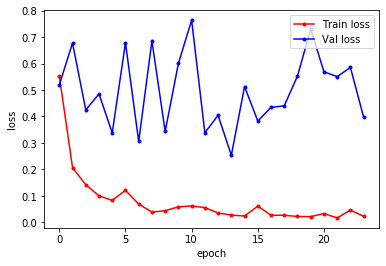

In [0]:
# 학습 데이터와 테스트 데이터의 Loss 그래프
train_loss = history.history['loss']  
val_loss = history.history['val_loss']

x = range(len(train_loss))
plt.plot(x, train_loss, marker='.', color='red', label='Train loss')
plt.plot(x, val_loss, marker='.', color='blue', label='Val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

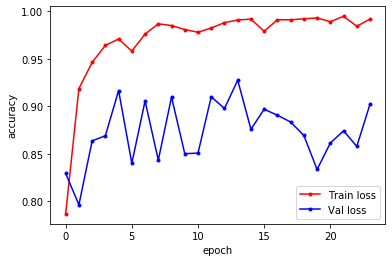

In [0]:
# 학습 데이터, 테스트 데이터의 정확도 그래프
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

x = range(len(train_accuracy))
plt.plot(x, train_accuracy, marker='.', color='red', label='Train loss')
plt.plot(x, val_accuracy, marker='.', color='blue', label='Val loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

**6. Confusion matrix**

In [0]:
# # 저장한 학습모델 불러옴.
categories = ["df", "mel", "nv", "tsu", "vl"]

# confusion matrix & classification report
print(y_test)

y_true = np.argmax(y_test, axis=1)   # 행 중 가장 큰값의 idx
# (one-hot-encoding 되어있으므로 1로 표시된 값을 행에서 가장 큰값으로 출력하여 array로 만듦)
print(y_true)
y_pred = np.argmax(model.predict(X_test), axis=1)
print(y_pred)

cm = confusion_matrix(y_true, y_pred)
print(cm)
# 세로가 실제클래스, 가로가 예측클래스
## 1 
# [[ 420  334   44   33    1]
#  [   1  860   68    1    0]
#  [   1  312  595    2    3]
#  [   1   20    2 1018    3]
#  [   0   13   18    4  819]]

report = classification_report(y_true, y_pred, target_names=categories)
print(report)
## 1
#               precision    recall  f1-score   support

#           df       0.99      0.50      0.67       832
#          mel       0.56      0.92      0.70       930
#           nv       0.82      0.65      0.73       913
#          tsu       0.96      0.98      0.97      1044
#           vl       0.99      0.96      0.97       854

#     accuracy                           0.81      4573
#    macro avg       0.86      0.80      0.81      4573
# weighted avg       0.86      0.81      0.81      4573


# [[0 0 1 0 0]
#  [1 0 0 0 0]
#  [0 0 0 0 1]
#  ...
#  [1 0 0 0 0]
#  [0 0 1 0 0]
#  [0 0 1 0 0]]
# [2 0 4 ... 0 2 2]
# [2 0 4 ... 0 2 2]
# [[ 758   26   41    5    2]
#  [   1  811   97   18    3]
#  [   2   65  842    4    0]
#  [   0    0    0 1043    1]
#  [   0    1    0    2  851]]
#               precision    recall  f1-score   support

#           df       1.00      0.91      0.95       832
#          mel       0.90      0.87      0.88       930
#           nv       0.86      0.92      0.89       913
#          tsu       0.97      1.00      0.99      1044
#           vl       0.99      1.00      0.99       854

#     accuracy                           0.94      4573
#    macro avg       0.94      0.94      0.94      4573
# weighted avg       0.94      0.94      0.94      4573


[[0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 ...
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]]
[2 0 4 ... 0 2 2]
[1 0 4 ... 0 1 2]
[[ 767   45    1   18    1]
 [   4  897   14   14    1]
 [  22  259  613   16    3]
 [   0    1    0 1043    0]
 [   0    0    0    7  847]]
              precision    recall  f1-score   support

          df       0.97      0.92      0.94       832
         mel       0.75      0.96      0.84       930
          nv       0.98      0.67      0.80       913
         tsu       0.95      1.00      0.97      1044
          vl       0.99      0.99      0.99       854

    accuracy                           0.91      4573
   macro avg       0.93      0.91      0.91      4573
weighted avg       0.93      0.91      0.91      4573

